In [ ]:
!pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from datasets import load_dataset

food = load_dataset("food101", split="train[:5000]")

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

c:\Users\alkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alkan\.cache\huggingface\hub\datasets--food101. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [3]:
food = food.train_test_split(test_size=0.2)

In [11]:
food["train"][0]["label"]

81

In [37]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers import ViTForImageClassification, ViTConfig
from tqdm.auto import tqdm
import wandb

In [ ]:
from transformers import AutoImageProcessor, SwinForImageClassification
import torch
from PIL import Image
from torchvision import transforms
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
model = SwinForImageClassification("microsoft/swin-small-patch4-window7-224")

In [ ]:
_transforms = Compose([ToTensor()])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [15]:
food = food.with_transform(transforms)

In [17]:
food["train"]

Dataset({
    features: ['image', 'label'],
    num_rows: 4000
})

In [18]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [19]:
from transformers import TrainingArguments, Trainer

In [24]:
from transformers import AutoConfig

In [34]:
config = AutoConfig.from_pretrained("microsoft/swin-small-patch4-window7-224")

In [ ]:
model = SwinForImageClassification(
    config=config,
)

TypeError: SwinForImageClassification.__init__() got an unexpected keyword argument 'num_labels'

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    processing_class=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
# Configuration for training
config = {
    "dataset": "food",  # Options: cifar10, cifar100, imagenet
    "image_size": 224,  # ViT input size
    "batch_size": 64,
    "num_workers": 4,
    "epochs": 100,
    "learning_rate": 3e-4,
    "weight_decay": 0.05,
    "warmup_steps": 500,
    "num_classes": 10,  # 10 for CIFAR-10, 100 for CIFAR-100, 1000 for ImageNet
    "patch_size": 16,
    "hidden_size": 768,
    "num_hidden_layers": 12,
    "num_attention_heads": 12,
    "intermediate_size": 3072,
    "dropout_rate": 0.1,
    "seed": 42,
    "save_dir": "./vit_model_checkpoints",
    "mixed_precision": True,  # Use mixed precision training (faster training with slight accuracy trade-off)
}

# Set random seed for reproducibility
torch.manual_seed(config["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config["seed"])

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create save directory if it doesn't exist
os.makedirs(config["save_dir"], exist_ok=True)

# Data preprocessing and augmentation
train_transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
if config["dataset"] == "cifar10":
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                             download=True, transform=train_transform)
    val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                           download=True, transform=val_transform)
elif config["dataset"] == "cifar100":
    train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                              download=True, transform=train_transform)
    val_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, 
                                            download=True, transform=val_transform)
elif config["dataset"] == "imagenet":
    # Requires ImageNet dataset to be downloaded and extracted
    train_dataset = torchvision.datasets.ImageNet(root='./data/imagenet', split='train', 
                                              transform=train_transform)
    val_dataset = torchvision.datasets.ImageNet(root='./data/imagenet', split='val', 
                                            transform=val_transform)
else:
    raise ValueError(f"Unsupported dataset: {config['dataset']}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], 
                         shuffle=True, num_workers=config["num_workers"], pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], 
                       shuffle=False, num_workers=config["num_workers"], pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Create custom ViT configuration
vit_config = ViTConfig(
    image_size=config["image_size"],
    patch_size=config["patch_size"],
    num_channels=3,
    num_classes=config["num_classes"],
    hidden_size=config["hidden_size"],
    num_hidden_layers=config["num_hidden_layers"],
    num_attention_heads=config["num_attention_heads"],
    intermediate_size=config["intermediate_size"],
    hidden_dropout_prob=config["dropout_rate"],
    attention_probs_dropout_prob=config["dropout_rate"]
)

# Initialize the model from scratch
model = ViTForImageClassification(vit_config)
print(f"Created ViT model with {sum(p.numel() for p in model.parameters())} parameters")

# Move model to device
model.to(device)

# Setup optimizer and scheduler
optimizer = optim.AdamW(
    model.parameters(),
    lr=config["learning_rate"],
    weight_decay=config["weight_decay"],
    betas=(0.9, 0.999)
)

# Learning rate scheduler
total_steps = len(train_loader) * config["epochs"]
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps)

# Set up mixed precision training if available and requested
scaler = torch.cuda.amp.GradScaler() if config["mixed_precision"] and torch.cuda.is_available() else None

# Training loop
best_val_acc = 0.0

for epoch in range(config["epochs"]):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]")
    
    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        if scaler is not None:
            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                outputs = model(inputs).logits
                loss = torch.nn.functional.cross_entropy(outputs, targets)
            
            # Scale the loss and perform backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard forward pass
            outputs = model(inputs).logits
            loss = torch.nn.functional.cross_entropy(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        # Update LR scheduler
        scheduler.step()
        
        # Record statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': train_loss / (batch_idx + 1),
            'acc': 100. * train_correct / train_total
        })
    
    train_acc = 100. * train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Val]")
        
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs).logits
            loss = torch.nn.functional.cross_entropy(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
            
            progress_bar.set_postfix({
                'loss': val_loss / (batch_idx + 1),
                'acc': 100. * val_correct / val_total
            })
    
    val_acc = 100. * val_correct / val_total
    
    # Print epoch results
    print(f"Epoch {epoch+1}/{config['epochs']} - "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Acc: {val_acc:.2f}%")
    
print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")

# Final evaluation on validation set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in tqdm(val_loader, desc="Final evaluation"):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs).logits
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calculate and print classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(all_targets, all_preds))

# Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config
}, os.path.join(config["save_dir"], "vit_final_model.pth"))

print(f"Final model saved to {os.path.join(config['save_dir'], 'vit_final_model.pth')}")

# Close wandb if used
if use_wandb:
    wandb.finish()

# Function to load the trained model for inference
def load_trained_vit(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    
    # Get the config from the checkpoint
    saved_config = checkpoint['config']
    
    # Create the model configuration
    vit_config = ViTConfig(
        image_size=saved_config["image_size"],
        patch_size=saved_config["patch_size"],
        num_channels=3,
        num_classes=saved_config["num_classes"],
        hidden_size=saved_config["hidden_size"],
        num_hidden_layers=saved_config["num_hidden_layers"],
        num_attention_heads=saved_config["num_attention_heads"],
        intermediate_size=saved_config["intermediate_size"],
        hidden_dropout_prob=saved_config["dropout_rate"],
        attention_probs_dropout_prob=saved_config["dropout_rate"]
    )
    
    # Initialize the model
    model = ViTForImageClassification(vit_config)
    
    # Load the model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Set to evaluation mode
    model.eval()
    
    return model.to(device)

# Example of how to use the trained model for inference
"""
# Load the model
model = load_trained_vit("./vit_model_checkpoints/vit_best_model.pth")

# Preprocess an image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and transform an image
from PIL import Image
image = Image.open("path_to_image.jpg")
image_tensor = transform(image).unsqueeze(0).to(device)

# Get prediction
with torch.no_grad():
    outputs = model(image_tensor).logits
    _, predicted_class = outputs.max(1)

print(f"Predicted class: {predicted_class.item()}")
"""

In [1]:
from data_processing import get_train_test_val_data_loaders
import os
import cv2
from PIL import Image

In [2]:
print(cv2.__version__)  # should print version like '4.9.0'

4.11.0


In [3]:
train_loader, valid_loader, test_loader = get_train_test_val_data_loaders("CHEMBL286", 32)

In [4]:
len(train_loader)

3099

In [5]:
path = r"c:\Users\alkan\OneDrive\Masaüstü\Dersler\HuBioLab\DEEPScreen2\training_files\target_training_datasets\CHEMBL286\imgs\CHEMBL314066_200.png"

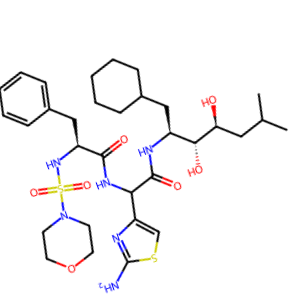

In [6]:
Image.open(path)

In [7]:
path2 = r"C:\Users\alkan\OneDrive\Resimler\Ekran Görüntüleri\Ekran görüntüsü 2025-04-26 001324.png"

In [9]:
img_array = cv2.imread(path2)
img_array

In [13]:
img_array = cv2.imread(path2)
cv2.imshow("Image", img_array)

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:973: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [7]:
item = next(iter(train_loader))

not none


FileNotFoundError: Image not found or cannot be read: c:\Users\alkan\OneDrive\Masaüstü\Dersler\HuBioLab\DEEPScreen2\training_files\target_training_datasets\CHEMBL286\imgs\CHEMBL2017099_50.png

In [8]:
os.path.exists(item["image"][0])

NameError: name 'item' is not defined